# Titanic Survival Prediction.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
def print_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data['Total'] > 0]

In [ ]:
def plot_learning_curve(estimator, X, y, title, train_sizes=np.linspace(.1, 1.0, 5), cv=None, n_jobs=1, ylim=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.grid()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    return plt

In [ ]:
def plot_validation_curve(estimator, X, y, title, param_name, param_range, cv=None, n_jobs=1, ylim=None):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training Score')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation Score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')

    plt.grid()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xscale('log')
    plt.xlabel('Parameter')
    plt.ylabel('Score')
    plt.legend(loc='best')
    return plt

## Minimum Viable Model

In [ ]:
train = pd.read_csv('train.csv')
train_raw = train.copy()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Variables:

* **PassengerId**. Unique identification of the passenger. It's not necessary for the model.
* **Survived**. Survival (0 = No, 1 = Yes). Target variable.
* **Pclass**. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
* **Name**. Name of the passenger.
* **Sex**. Sex (male, female)
* **Age**. Age in years.
* **SibSp**. number of siblings / spouses aboard the Titanic.
* **Parch**. number of parents / children aboard the Titanic.
* **Ticket**. Ticket number.
* **Fare**. Passenger fare.
* **Cabin**. Cabin number.
* **Embarked**. Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The max value of the fare is far higher than the 75th percentile. We'll explore this variable later.

For now, let's prepare the data for our Minimum Viable Model.

In [ ]:
print_missing_data_table(train)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


We'll just drop or simply impute the missing data.

In [ ]:
train.drop('Cabin', axis=1, inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [ ]:
train['Age'].fillna(1000, inplace=True)
train['Age'].isnull().any()

False

In [ ]:
train.dropna(subset='Embarked', inplace=True)
train['Embarked'].isnull().any()

False

Do a simple feature engineering.

In [ ]:
train['Sex'] = pd.Categorical(train['Sex'])
train['Embarked'] = pd.Categorical(train['Embarked'])
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [ ]:
train['FamilySize'] = train['SibSp'] + train['Parch']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [ ]:
train.drop('PassengerId', axis=1, inplace=True)
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
train.drop(['Name', 'Ticket'], axis=1, inplace=True)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [ ]:
train = pd.get_dummies(train, drop_first=True)
train.head()

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,1,0,1
1,1,1,38.0,71.2833,1,0,0,0
2,1,3,26.0,7.9250,0,0,0,1
3,1,1,35.0,53.1000,1,0,0,1
4,0,3,35.0,8.0500,0,1,0,1


Then train the data using Logistic Regression.

In [ ]:
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print(f'CV Accuracy: {np.mean(scores)} +/- {np.std(scores)}')

CV Accuracy: 0.7862089201877934 +/- 0.030768248225338534


### Model Performance

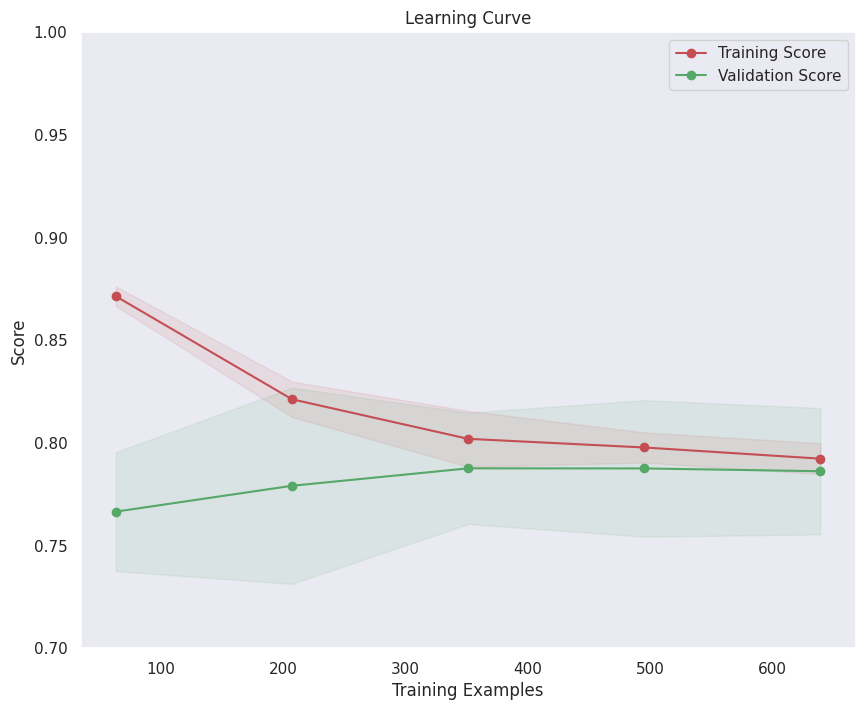

In [ ]:
title = "Learning Curve"
plot_learning_curve(logreg, X_train, y_train, title, cv=10, n_jobs=1, ylim=(0.7, 1.0));

From the above plot, we can see that our model underfits the data. We achieve only 78% accuracy using our simple data.

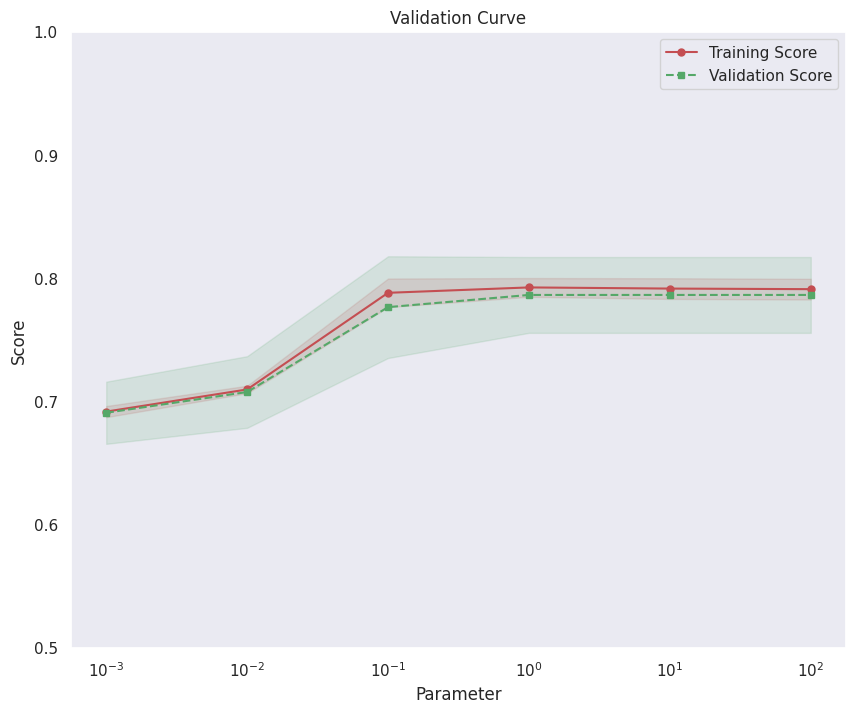

In [ ]:
title = 'Validation Curve'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
plot_validation_curve(logreg, X_train, y_train, title, param_name=param_name, param_range=param_range, cv=10, ylim=(0.5, 1.0));

It seems like the C parameter of 1 is the best for our model.

Now, it's time to improve 😁.

## Unicorn Model

### Exploratory Data Analysis + Data Preprocessing

Hypothesis:

* **PassengerId**. Unique identification of each passenger. It's not relevant to our analysis.
* **Survived**. The target variable.
* **Pclass**. First class should have a higher survival rate.
* **Name**. Names, accompanied by a title, can lead to different forms of treatment.
* **Sex**. Women should have a higher survival rate than man.
* **Age**. Children are usually evacuated first in a disaster, so they should have a higher survival rate.
* **SibSp**. The more people there are, the lower the survival rate.
* **Parch**. It should play with 'SibSp'.
* **Ticket**. Ticket number shouldn't be important for prediction purposes.
* **Fare**. Higher fare should have a higher survival rate.
* **Cabin**. The cabin number might indicate where people were during the disaster. It might have some influence in survival chances.
* **Embarked**. It's not expectable that people coming from Cherbourg are more unlucky than people coming from Southampton. So, this variable shouldn't be important.

In [ ]:
train = train_raw.copy()

#### Pclass

Our hypothesis is that the higher the class, the higher the chances of survival. This means that a person travelling in the first class has a higher chance of survival than a person traveling on the second or third class.

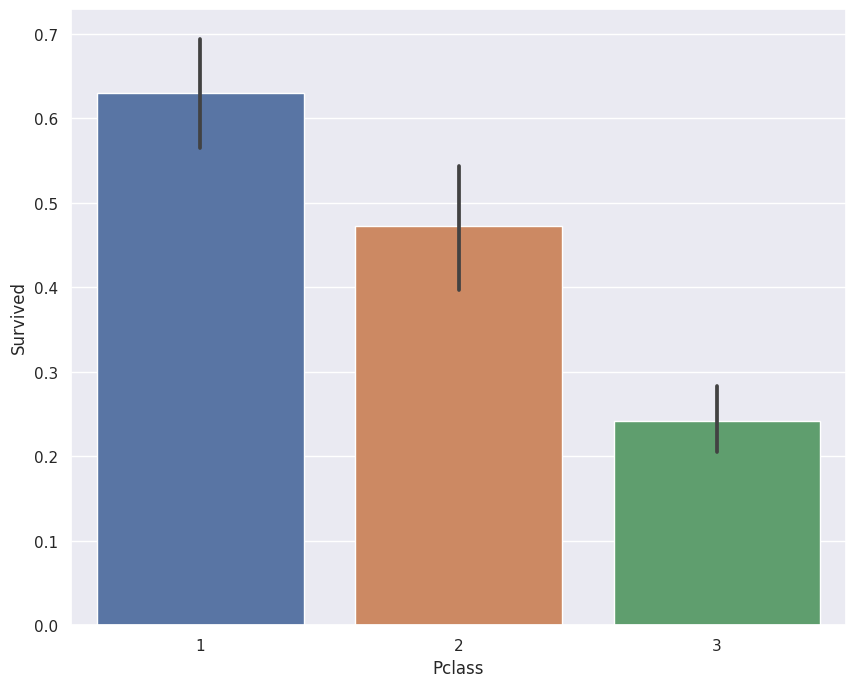

In [ ]:
sns.barplot(data=train, x='Pclass', y='Survived');

As we can see, about 60% of the people travelling in the first class survived. In contrast, only approximately 25% of the people travelling in the third class survived.

#### Name/Title

Our assumption is that people's title influences how they are treated.

In [ ]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
train['Title'] = train['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [ ]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

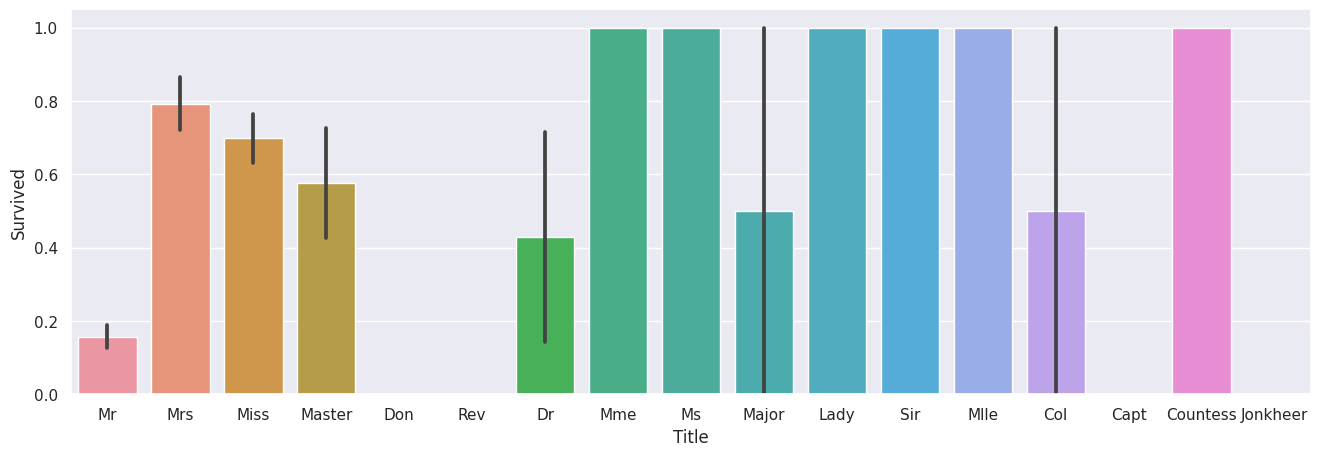

In [ ]:
plt.figure(figsize=(16, 5))
sns.barplot(data=train, x='Title', y='Survived');

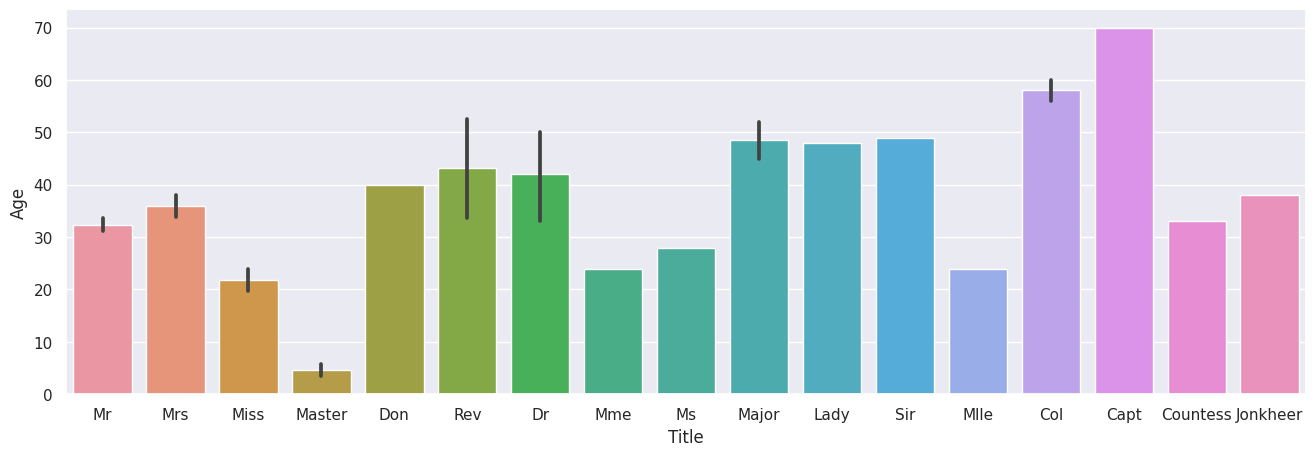

In [ ]:
plt.figure(figsize=(16, 5))
sns.barplot(data=train, x='Title', y='Age');

We can group some of the titles and simplify our analysis.

In [ ]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [ ]:
titles_dict = {'Mr': 'Mr',
               'Miss': 'Miss',
               'Mrs': 'Mrs',
               'Master': 'Master',
               'Dr': 'Other',
               'Rev': 'Other',
               'Mlle': 'Miss',
               'Major': 'Military',
               'Col': 'Military',
               'Countess': 'Noble',
               'Capt': 'Military',
               'Ms': 'Miss',
               'Sir': 'Noble',
               'Lady': 'Noble',
               'Mme': 'Mrs',
               'Don': 'Mr',
               'Jonkheer': 'Noble'}

train['TitleGroup'] = train['Title'].map(titles_dict)
train['TitleGroup'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: TitleGroup, dtype: object

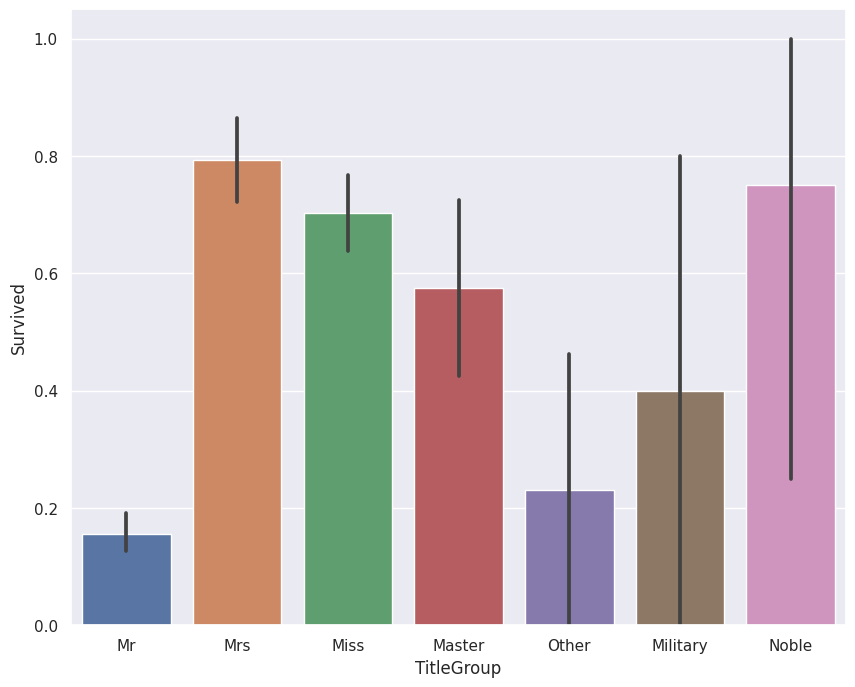

In [ ]:
sns.barplot(data=train, x='TitleGroup', y='Survived');

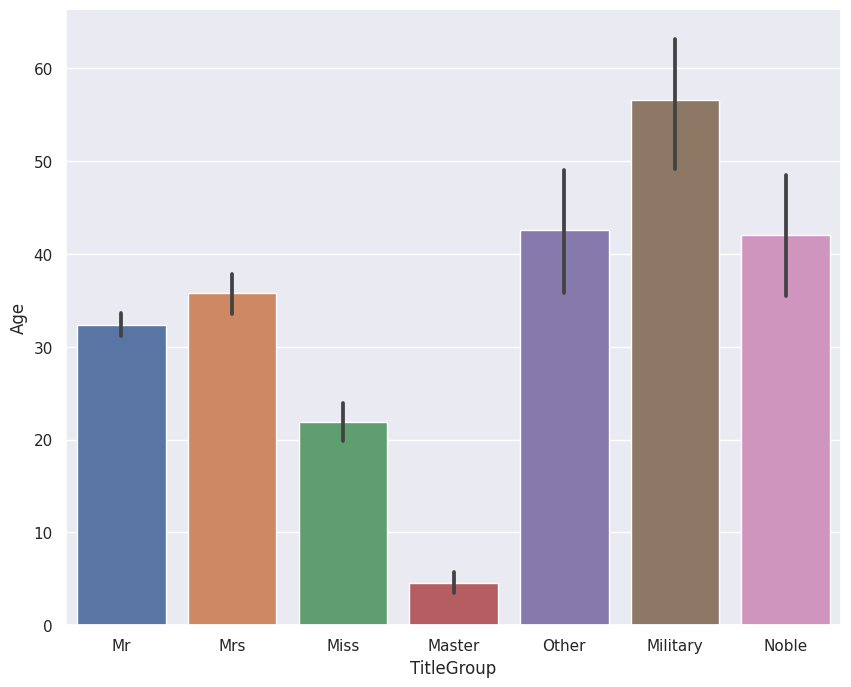

In [ ]:
sns.barplot(data=train, x='TitleGroup', y='Age');

Our results suggest that:
* People with the title 'Mr' survived less than people with any other title.
* Titles with a survival rate higher than 50% are those that correspond to female (Miss or Mrs), children (Master) or Noble.
* As we can see by the error bar (black line), there is significant uncertainty around the mean value, especially in the Other, Military, and Noble categories. This can happen because we have limited data in these categories.

#### Sex

We already have some clues that, in Titanic, women had a higher survival rate.

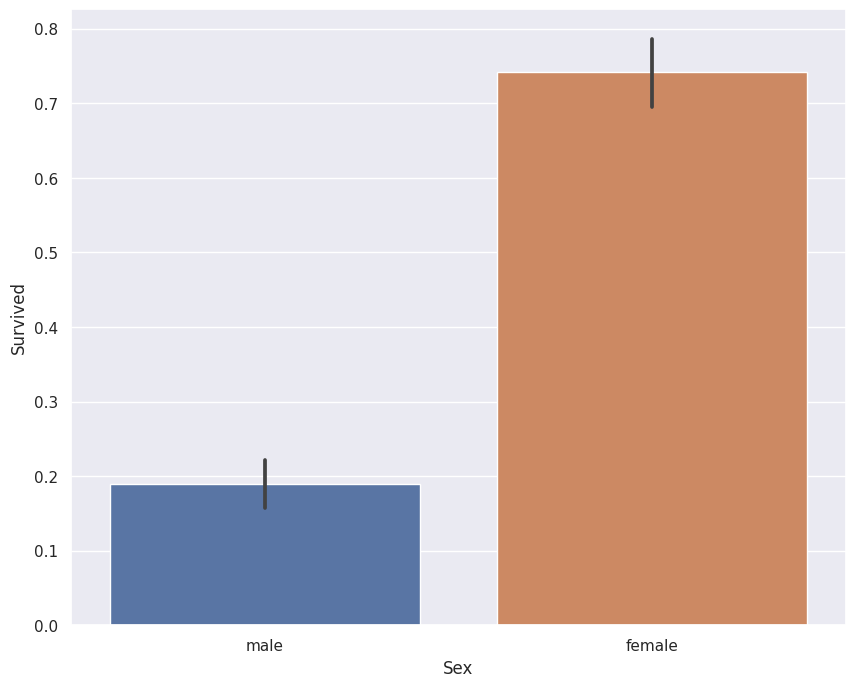

In [ ]:
sns.barplot(data=train, x='Sex', y='Survived');

Our hypothesis seems to be right.

#### Age

Our hypothesis is that children are more prone to survive, while people in its adult life may have a lower rate of survival.

We'll impute age data by using the mean age of the title to which the person belongs.

In [ ]:
means = train.groupby('Title')['Age'].mean().astype(int)
map_means = means.to_dict()
map_means

{'Capt': 70,
 'Col': 58,
 'Countess': 33,
 'Don': 40,
 'Dr': 42,
 'Jonkheer': 38,
 'Lady': 48,
 'Major': 48,
 'Master': 4,
 'Miss': 21,
 'Mlle': 24,
 'Mme': 24,
 'Mr': 32,
 'Mrs': 35,
 'Ms': 28,
 'Rev': 43,
 'Sir': 49}

In [ ]:
idx_nan_age = train[train['Age'].isnull()].index
train.loc[idx_nan_age, 'Age'] = train['Title'].loc[idx_nan_age].map(map_means)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitleGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr


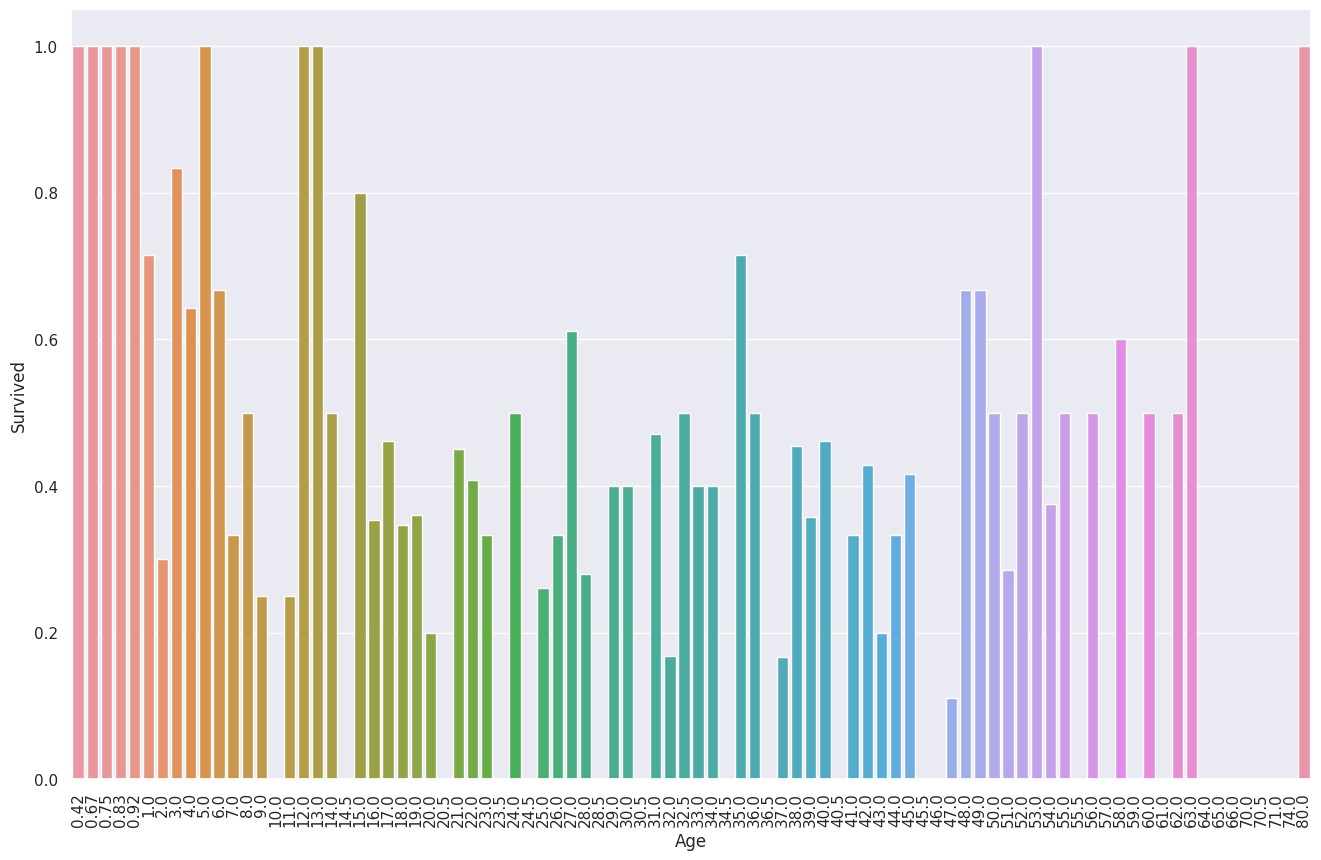

In [ ]:
plt.figure(figsize=(16, 10))
sns.barplot(data=train, x='Age', y='Survived', errorbar=None)
plt.xticks(rotation=90);

Then, we'll group these age to three categories, Child, Adult, and Elder.

In [ ]:
train['Age'] = pd.cut(train['Age'], bins=[0, 15, 50, 100], labels=['Child', 'Adult', 'Elder'])
train['Age'].head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age, dtype: category
Categories (3, object): ['Child' < 'Adult' < 'Elder']

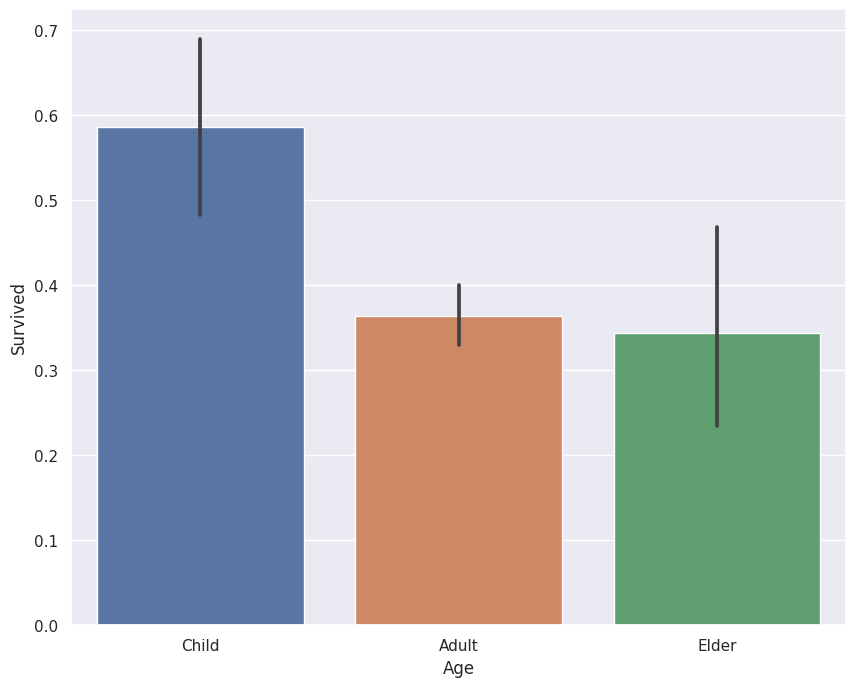

In [ ]:
sns.barplot(data=train, x='Age', y='Survived');

The plot shows that children have a higher survival rate. It also shows that, there is not a significant difference of survival chance between the categories 'Adult' and 'Elder'.

#### FamilySize

Regarding family size, our hypothesis is that the more people a person travel with, the lower the survival rate.

In [ ]:
train['FamilySize'] = train['SibSp'] + train['Parch']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitleGroup,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,Adult,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,Adult,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult,1,0,113803,53.1000,C123,S,Mrs,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,Adult,0,0,373450,8.0500,NaN,S,Mr,Mr,0


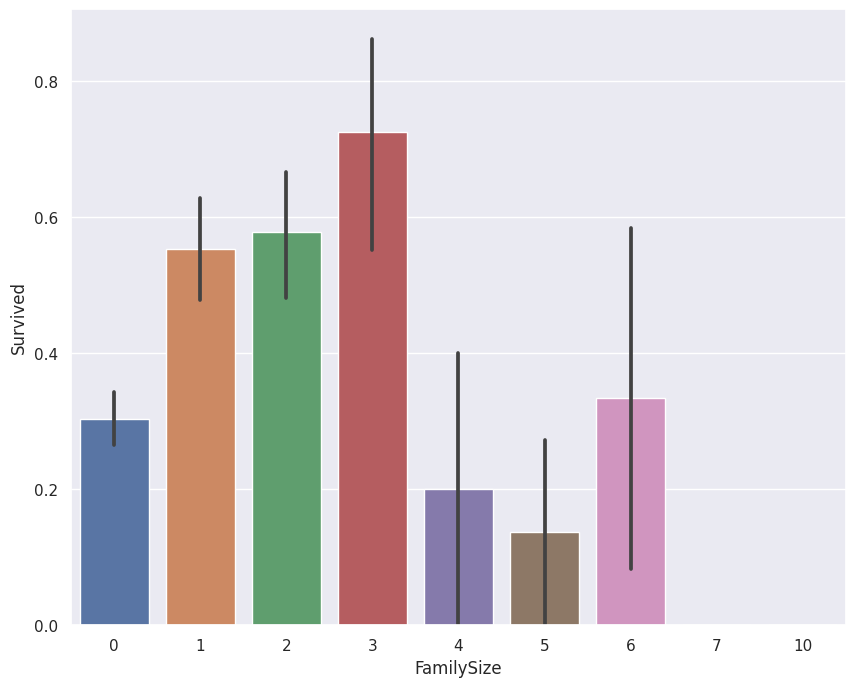

In [ ]:
sns.barplot(data=train, x='FamilySize', y='Survived');

As we can see, our hypothesis finds some support when FamilySize is higher than 3.

#### Fare

The higher fares, the higher survival rate.

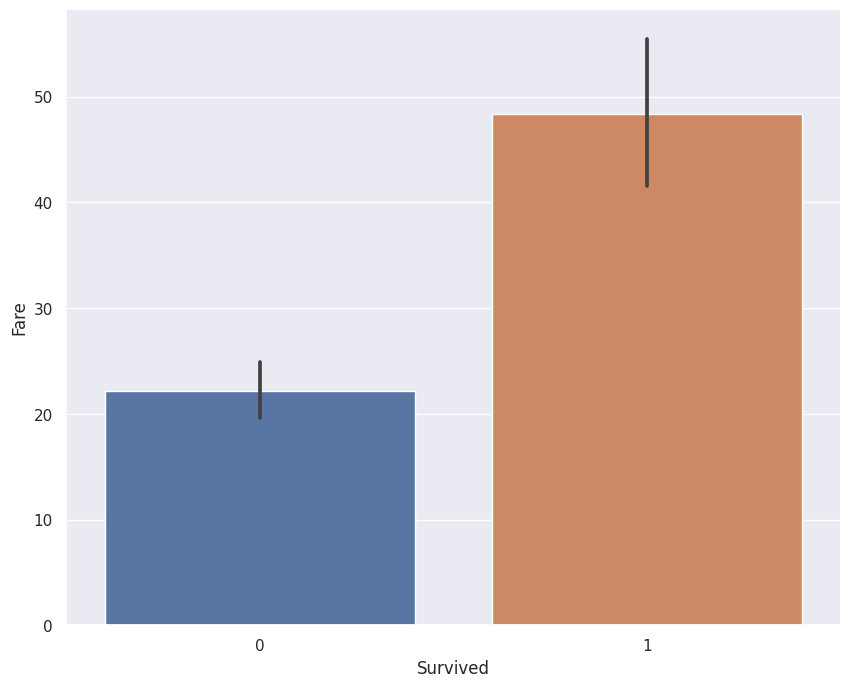

In [ ]:
sns.barplot(data=train, x='Survived', y='Fare');

The plot suggests that those who survived paid a higher fare.

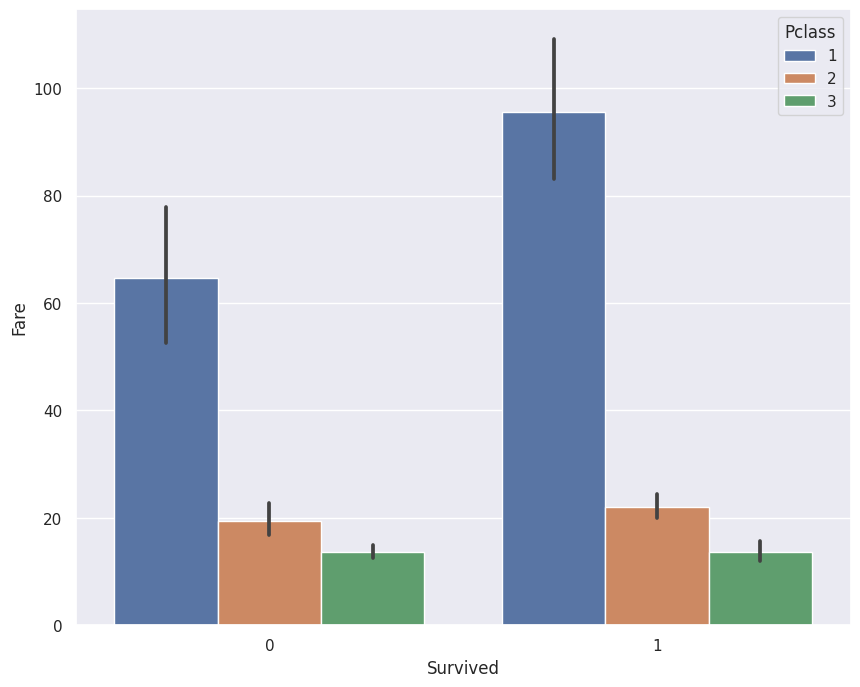

In [ ]:
sns.barplot(data=train, x='Survived', y='Fare', hue='Pclass');

Here we have an interesting result. It seems that 'Fare' doesn't make difference, in terms of survival, if you are travelling in second or third class. However, if you are travelling in first class, the higher the fare, the higher the chances of survival.

#### Cabin

People in certain cabin might have a higher survival chance because it closer to the exit?

In [ ]:
train['Cabin'] = train['Cabin'].str.extract(r'([a-zA-z]+)')
train['Cabin'].fillna('None', inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitleGroup,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,Adult,1,0,A/5 21171,7.2500,None,S,Mr,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Adult,1,0,PC 17599,71.2833,C,C,Mrs,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,Adult,0,0,STON/O2. 3101282,7.9250,None,S,Miss,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Adult,1,0,113803,53.1000,C,S,Mrs,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,Adult,0,0,373450,8.0500,None,S,Mr,Mr,0


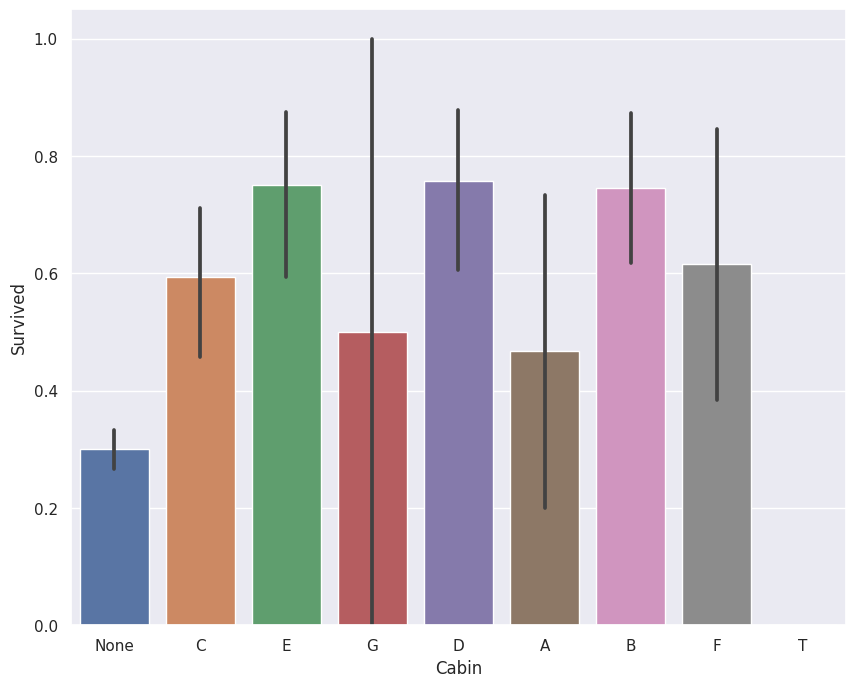

In [ ]:
sns.barplot(data=train, x='Cabin', y='Survived');

It seems that people that doesn't belong to the cabins have lower survival rate.

#### Embarked

The hypothesis regarding 'Embarked' is that it doesn't influence the chances of survival.

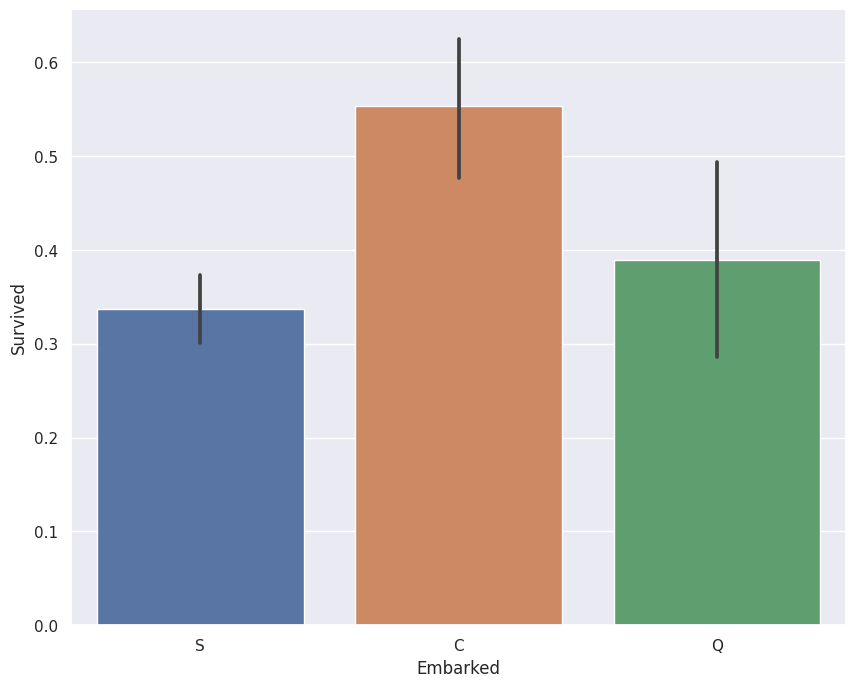

In [ ]:
sns.barplot(data=train, x='Embarked', y='Survived');

It seems that people embarking on C had a higher survival rate. Hmm, let's dive deeper.

In [ ]:
train.groupby(['Embarked'])['Fare'].mean()

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

It seems that people embarking on C were paying more than people embarking on Q and S. Maybe that's why?

In [ ]:
train.groupby(['Embarked', 'Age'])['PassengerId'].count()

Embarked  Age  
C         Child     20
          Adult    133
          Elder     15
Q         Child      5
          Adult     69
          Elder      3
S         Child     62
          Adult    537
          Elder     45
Name: PassengerId, dtype: int64

No significant differences can be found.

In [ ]:
train.groupby(['Embarked', 'Sex'])['PassengerId'].count()

Embarked  Sex   
C         female     73
          male       95
Q         female     36
          male       41
S         female    203
          male      441
Name: PassengerId, dtype: int64

No significant differences can be found.

Considering the results above, It seems that the embarkment point doesn't influence the survival rate. What really seems to be influencing is the class where people were travelling and how much they were spending.

Now, let's prepare the data for the Logistic Regression Model.

In [ ]:
train.drop('PassengerId', axis=1, inplace=True)
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
train.drop(['Name', 'Title', 'Ticket'], axis=1, inplace=True)

In [ ]:
train['TitleGroup'] = pd.Categorical(train['TitleGroup'])
train['Sex'] = pd.Categorical(train['Sex'])
train['Cabin'] = pd.Categorical(train['Cabin'])
train['Embarked'] = pd.Categorical(train['Embarked'])

In [ ]:
train = pd.get_dummies(train, drop_first=1)
train.head()

,Survived,Pclass,Fare,FamilySize,Sex_male,Age_Adult,Age_Elder,Cabin_B,Cabin_C,Cabin_D,...,Cabin_None,Cabin_T,Embarked_Q,Embarked_S,TitleGroup_Military,TitleGroup_Miss,TitleGroup_Mr,TitleGroup_Mrs,TitleGroup_Noble,TitleGroup_Other
0,0,3,7.2500,1,1,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,1,1,71.2833,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,3,7.9250,0,0,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
3,1,1,53.1000,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,0,3,8.0500,0,1,1,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train['Fare'] = scaler.fit_transform(X_train[['Fare']])
X_test['Fare'] = scaler.fit_transform(X_test[['Fare']])

### Feature Engineering

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2).fit(X_train.values)
X_train_poly = poly.transform(X_train.values)
X_test_poly = poly.transform(X_test.values)

In [ ]:
poly.get_feature_names_out()

array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x21', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4',
       'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11',
       'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17',
       'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x1^2', 'x1 x2', 'x1 x3',
       'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10',
       'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16',
       'x1 x17', 'x1 x18', 'x1 x19', 'x1 x20', 'x1 x21', 'x2^2', 'x2 x3',
       'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10',
       'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x2 x15', 'x2 x16',
       'x2 x17', 'x2 x18', 'x2 x19', 'x2 x20', 'x2 x21', 'x3^2', 'x3 x4',
       'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11',
       'x3 x12', 'x3 x13', 'x3 x14', 'x3 x15', 'x3 x16', 'x3 x17',
       'x3 

### Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=10)
# print(f'CV Accuracy: {np.mean(scores)} +/- {np.std(scores)}')
highest_score = np.mean(scores)

for i in range(1, X_train_poly.shape[1] + 1, 1):
    select = SelectKBest(score_func=chi2, k=i)
    select.fit(X_train_poly, y_train)
    X_train_poly_selected = select.transform(X_train_poly)

    logreg.fit(X_train_poly_selected, y_train)
    scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
    # print(f'CV Accuracy (Number of Features = {i}): {np.mean(scores)} +/- {np.std(scores)}')

    if np.mean(scores) > highest_score:
        highest_score = np.mean(scores)
        std = np.std(scores)
        k_features_highest_score = i
    elif np.mean(scores) == highest_score:
        if np.std(scores) < std:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = i

print(f'Number of Features when Highest Score: {k_features_highest_score}')

Number of Features when Highest Score: 33


In [ ]:
select = SelectKBest(score_func=chi2, k=k_features_highest_score)
select.fit(X_train_poly, y_train)
X_train_poly_selected = select.transform(X_train_poly)

In [ ]:
logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train_poly_selected, y_train)

LogisticRegression(C=1, max_iter=1000)

In [ ]:
scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
print(f'CV Accuracy: {np.mean(scores)} +/- {np.std(scores)}')

CV Accuracy: 0.8315140845070422 +/- 0.03585527070771353


We get a better accuracy score. Yeay!

### Model Performance

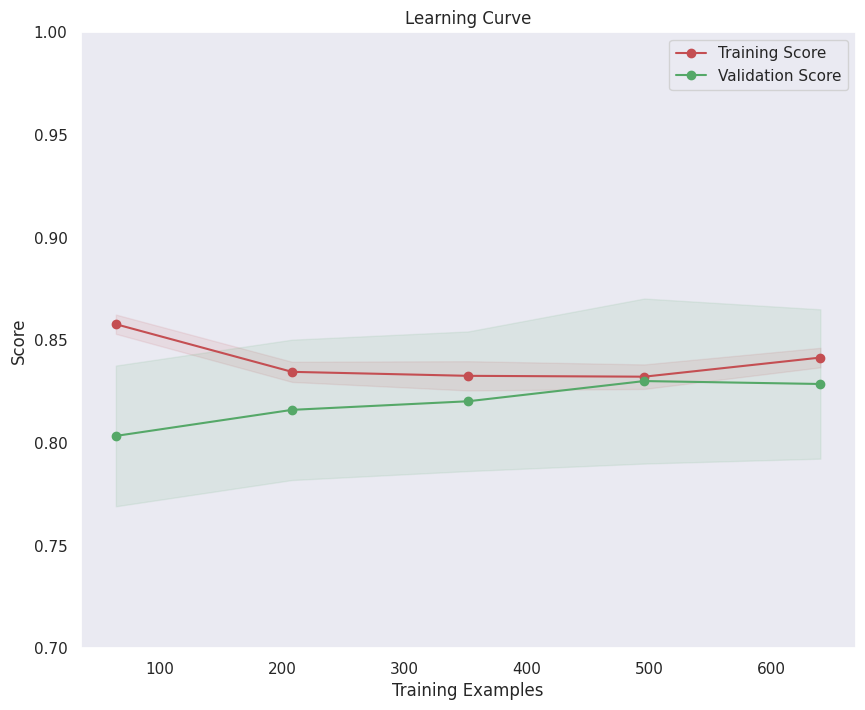

In [ ]:
title = "Learning Curve"
plot_learning_curve(logreg, X_train, y_train, title, cv=10, n_jobs=1, ylim=(0.7, 1.0));

It seems that our model overfits the data when training examples are more than 500.

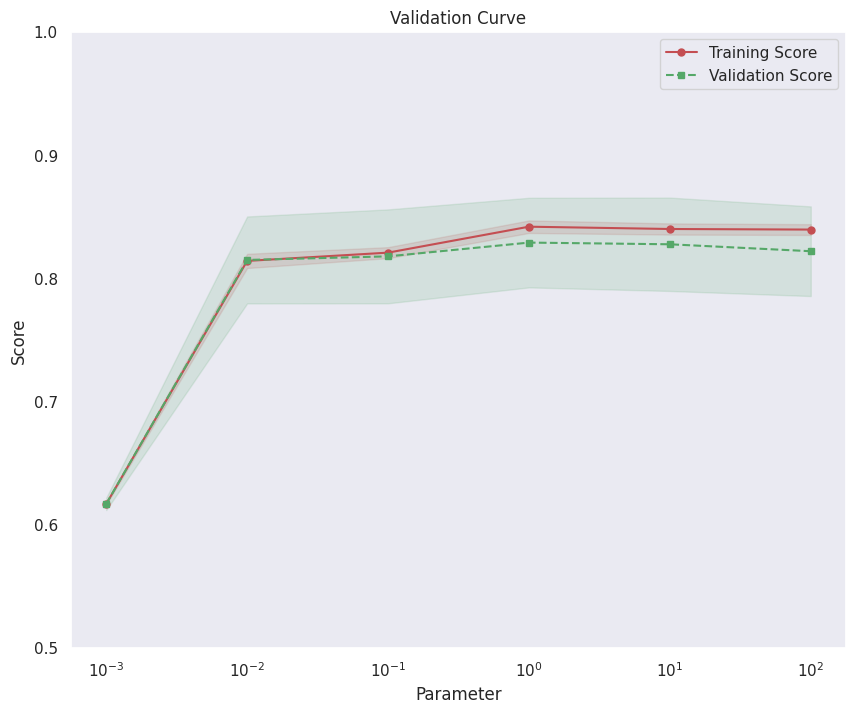

In [ ]:
title = 'Validation Curve'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
plot_validation_curve(logreg, X_train, y_train, title, param_name=param_name, param_range=param_range, cv=10, ylim=(0.5, 1.0));

We used C=1, which is on the edge of overfitting.